## Trying to build a full 3 layer neural net from scratch using MNIST data

In [7]:
import tensorflow as tf
import sys
import numpy as np 

#From my own library
from computer_vision.my_lib.blur_contrast import display_image

In [8]:
sys.path.append('/Users/jacoblourie')

In [9]:
#Load the dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#x_train, x_test = x_train / 255.0, x_test / 255.0

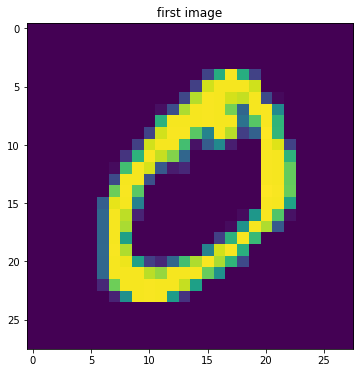

In [10]:
#see what an image looks like
display_image(x_train[1],'first image', size=(6,6))

We want to run a 1/0 model, so let's label all "1"s as 1, and everything else as 0

In [11]:
binary_y_train = np.array([1 if y == 1 else 0 for y in y_train])
binary_y_test = np.array([1 if y == 1 else 0 for y in y_test])

Let's go for 2 hidden layers, of 50 and 50 levels and let's just use sigmoid functions for now

In [12]:
#this helps much simpler
x_train_flat = x_train.reshape((60000,-1)).T
x_test_flat = x_test.reshape((10000,-1)).T
print(x_test_flat.shape)
y_train_transp = y_train.reshape(1,-1)
y_test_transp = y_test.reshape(1,-1)

#Create the binary model
bin_y_train = binary_y_train.reshape(1,-1)
bin_y_test = binary_y_test.reshape(1,-1)


(784, 10000)


In [13]:
#Let's create the 'weights' matrices
np.random_state = 112
layer_1 = 50
layer_2 = 50
size_of_layer = [x_train_flat.shape[0], layer_1,layer_2, 1]
dict_of_matrices = {}
dict_of_biases = {}

for layer in range(len(size_of_layer) - 1):
    dict_of_matrices[f"W{layer+1}"] = np.random.randn(size_of_layer[layer+1],size_of_layer[layer])
    dict_of_biases[f"B{layer+1}"] = np.random.randn(size_of_layer[layer+1],1)
#Print the sizes of the matrix
print(f"Weights matrices")
for name, matrix in dict_of_matrices.items():
    print(name, matrix.shape)

print(f"Biases")
for name, matrix in dict_of_biases.items():
    print(name, matrix.shape)

Weights matrices
W1 (50, 784)
W2 (50, 50)
W3 (1, 50)
Biases
B1 (50, 1)
B2 (50, 1)
B3 (1, 1)


OK we've gone with a gaussian initialisation of the matrices. We'll come back to this

In [77]:
#FORWARD PROPOGATION

#we'll use this function a lot
def sigmoid(x):
    return (1/(1+np.exp(-x)))

#let's create the first level
Z1 = dict_of_matrices['W1'] @ x_train_flat + dict_of_biases['B1']
A1 = sigmoid(Z1)

#Then second level
Z2 = dict_of_matrices['W2'] @ A1 + dict_of_biases['B2']
A2 = sigmoid(Z2)

#Then output level

Z3 = dict_of_matrices['W3'] @ A2 + dict_of_biases['B3']
A3 = sigmoid(Z3)


<ipython-input-77-aec1858ea069>:5: RuntimeWarning: overflow encountered in exp
  return (1/(1+np.exp(-x)))


In [78]:
Z2.shape

(50, 60000)

#Now let's create the cost function

In [15]:
#We'll use v. basic, none logged cost function for now
Cost = ((bin_y_train - A3) @ np.transpose(bin_y_train - A3) / A3.size )[0]
print(Cost)

[0.39671828]


## Great, so now we need to do back propogation.

differential of sigmoid is 

In [110]:
W1, W2, W3 = dict_of_matrices.values()
B1, B2, B3 = dict_of_biases.values()

'''Let's look at W3 and B3 first'''
#dC / dB = dC/dA * dA/dZ * dZ / dB
#dC / dW = dC/dA * dA/dZ * dZ / dW

#GO BACK ONE LAYER
dC_dA3 = 2*(A3 - bin_y_train)/A3.size #gives 1 by m matrix
dA3_dZ3 = np.exp(-Z3) / ((1+np.exp(-Z3))**2) #still gives 1 x m matrix
dC_dZ3 = dC_dA3 * dA3_dZ3 #still a 1 x m matirx

#Get differentials at first layer
dZ3_dW3 = A2 #should be a 50 x m matrix (all a values)
dZ3_dB3 = np.zeros_like((Z3)) + 1 #we need a 1 x m matrix

'''First useful differentials'''
dC_dW3 = dC_dZ3 @ dZ3_dW3.T 
dC_dB3 = dC_dZ3 @ dZ3_dB3.T

In [111]:
Z3.shape

(1, 60000)

Worth nothing, that everything is positive - this kind of makes sense because right now the dumb model can be improved by just setting everything to 0 (as only 10% of outputs are "1")

Let's keep going back through the differentials

In [117]:
#first, get the A2 layer
#dC / dA2 ~ dC/DZ3 * dZ3 / dA2
dZ3_dA2 =  W3 # z = WA + b. 1 x 50
dC_dA2 = (dC_dZ3.T @ dZ3_dA2).T #50 rows, each column is back to being a training example, and there are W2.column_size rows.

#then repeat the back_prop from before
dA2_dZ2 = np.exp(-Z2) / ((1+np.exp(-Z2))**2) #still gives 50 x m
dC_dZ2 = dC_dA2 * dA2_dZ2 #still a 50 x m

dZ2_dW2 = A1 # which is now 50 x m (A1 also 50 x m)
dZ2_dB2 = np.zeros_like((Z2)) + 1 #we need a 50 x 1 matrix

'''Second useful differentials'''
dC_dW2 = dC_dZ2 @ dZ2_dW2.T  #W2 is 50x 50. dC_dZ2 is a 50 x m , by dz2_dw2 which is a 50xm, but tranpose
dC_dB2 = np.sum(dC_dZ2 @ dZ2_dB2.T,axis=1,keepdims=True)



In [122]:
print(dC_dW2.shape)
print(dZ3_dA2.shape)
print(dC_dA2.shape)
print(dC_dZ2.shape)
print(dZ2_dB2.shape)
print(dZ2_dW2.shape)
print(dC_dB2)

(50, 50)
(1, 50)
(50, 60000)
(50, 60000)
(50, 60000)
(50, 60000)
[[-1.37067023e-01]
 [ 2.04463687e-01]
 [-1.70030127e-04]
 [-2.42275240e-01]
 [-2.92847746e-01]
 [-8.68131605e-02]
 [ 5.32091245e-01]
 [ 6.66202949e-02]
 [-1.93101601e-01]
 [ 1.79458899e-01]
 [-4.22450924e-01]
 [ 8.21230490e-02]
 [-1.24152909e+00]
 [-3.37163159e-01]
 [ 7.51613444e-02]
 [ 7.45289635e-03]
 [-2.41152198e-01]
 [ 3.23960516e-02]
 [-3.59331488e-01]
 [-3.84712157e-02]
 [ 7.92505684e-03]
 [-2.49587042e-01]
 [-6.89678445e-02]
 [ 2.27399071e-01]
 [-8.65749829e-01]
 [-8.29479918e-01]
 [ 6.69630900e-02]
 [ 7.14210407e-01]
 [-3.33945327e-01]
 [ 3.76645100e-01]
 [-8.46709907e-02]
 [-1.85060635e+00]
 [-2.28353422e+00]
 [ 2.19238712e-01]
 [-4.50288962e-01]
 [ 3.24044105e-01]
 [ 5.67913349e-01]
 [ 4.44704047e-01]
 [ 3.78659836e-01]
 [ 5.78568334e-01]
 [-3.52850209e-02]
 [ 5.64097110e-01]
 [-6.50604062e-01]
 [ 5.81594052e-01]
 [-2.32693133e-01]
 [-2.48312291e-01]
 [ 7.78029047e-01]
 [-1.53743234e-02]
 [ 1.16401257e+00]
 [ 8

In [71]:
dZ2_dB2.shape

(50, 60000)